In [1]:
import os
import glob
import numpy as np
import pandas as pd
import shapely.wkt
from PIL import Image
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
root_dir="../data"
bbox_path="images_bboxes.csv"
images_path="images"


In [3]:
bboxes_df = pd.read_csv(f"{root_dir}/{bbox_path}")
bboxes_df.head()

,image_id,worm_type,geometry
0,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((2478.89 156.77, 2478.89 297.86, 2377..."
1,id_8ada71185e18dc8838b4925b.jpg,pbw,"POLYGON ((939.8199999999999 1221.46, 939.81999..."
2,id_8ada71185e18dc8838b4925b.jpg,abw,"POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129...."
3,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2090.216399557101 1537.2100674812148...
4,id_bc86d3cfd0c0463fa5cae33e.jpg,abw,POLYGON ((2342.2568587778546 1676.304250464547...


## The Distribution of Image Size

In [4]:
all_image_ids = glob.glob(f'{root_dir}/{images_path}/*')
all_image_ids = [os.path.basename(image_id) for image_id in all_image_ids]

In [5]:
train_ids = []
train_heights = []
train_widths = []

for _, row in tqdm(bboxes_df.iterrows()):
    if row["image_id"] not in train_ids:
        im_height, im_width = Image.open(f'{root_dir}/{images_path}/{row["image_id"]}').size
        train_ids.append(row["image_id"])
        train_heights.append(im_height)
        train_widths.append(im_width)

0it [00:00, ?it/s]

In [6]:
test_ids = list(set(all_image_ids) - set(train_ids))
test_heights = []
test_widths = []

for image_id in tqdm(test_ids):
    im_height, im_width = Image.open(f'{root_dir}/{images_path}/{image_id}').size
    test_heights.append(im_height)
    test_widths.append(im_width)

  0%|          | 0/2803 [00:00<?, ?it/s]

In [7]:
print(len(train_ids), len(test_ids))

9737 2803


max height: 9280
min height: 172


<AxesSubplot: xlabel='height', ylabel='Count'>

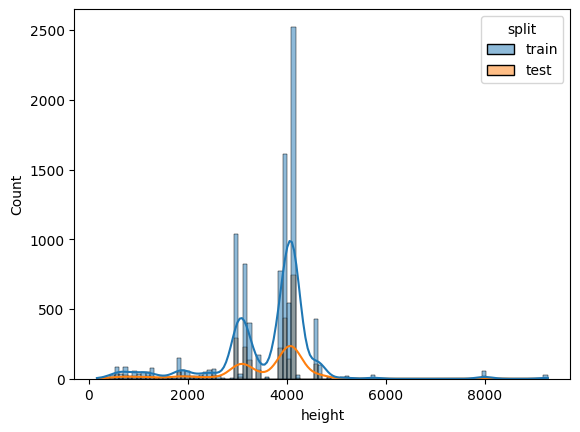

In [51]:
print("max height:", max(train_heights))
print("min height:", min(test_heights))

sns.histplot(data={
    "height": train_heights + test_heights,
    "split": ["train"]*len(train_heights) + ["test"]*len(test_heights)
    }, x="height", hue="split", kde=True)

max height: 6944
min height: 72


<AxesSubplot: xlabel='width', ylabel='Count'>

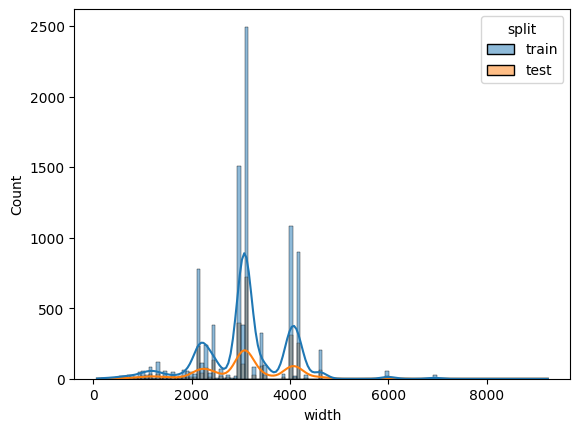

In [52]:
print("max height:", max(train_widths))
print("min height:", min(test_widths))

sns.histplot(data={
    "width": train_widths + test_widths,
    "split": ["train"]*len(train_widths) + ["test"]*len(test_widths)
    }, x="width", hue="split", kde=True)

## Number of insects per image

In [53]:
bollworms_per_images = bboxes_df[bboxes_df["worm_type"].notnull()].groupby("image_id").apply(lambda x: len(x))
bollworms_per_images.head()

image_id
id_0002ea6f15c7fa6f4c221783.jpg    51
id_0005ef295aafe6acc63587db.jpg     8
id_00093f2c76f6488737325859.jpg    12
id_000b2e6c437c643f25d4a6c3.jpg    87
id_001149c0de05ea4941d966e0.jpg     5
dtype: int64

max num bollworms: 527
min num bollworms: 1


<AxesSubplot: xlabel='num_bollworms', ylabel='Count'>

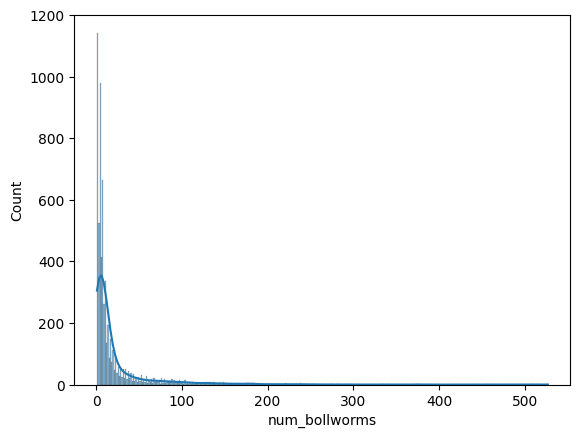

In [54]:
print("max num bollworms:", max(bollworms_per_images.values))
print("min num bollworms:", min(bollworms_per_images.values))

sns.histplot(data={
    "num_bollworms": bollworms_per_images.values
    }, x="num_bollworms", kde=True)

## Distribuiton of the number of insect classes per image

In [60]:
classes_images = bboxes_df[bboxes_df["worm_type"].notnull()].groupby(["image_id", "worm_type"]).apply(lambda x: len(x))
classes_images.head()

image_id                         worm_type
id_0002ea6f15c7fa6f4c221783.jpg  pbw          51
id_0005ef295aafe6acc63587db.jpg  pbw           8
id_00093f2c76f6488737325859.jpg  pbw          12
id_000b2e6c437c643f25d4a6c3.jpg  pbw          87
id_001149c0de05ea4941d966e0.jpg  abw           5
dtype: int64

max abw bollwroms: 23
min abw bollwroms: 1
max pbw bollwroms: 527
min pbw bollwroms: 1


<AxesSubplot: xlabel='num_bollworms', ylabel='Count'>

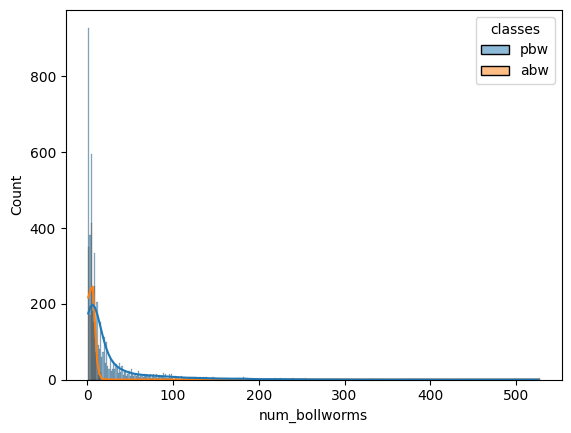

In [77]:
classes_per_images = [[item[0][1], item[1]] for item in list(zip(classes_images.index.to_list(), classes_images.values))]

print("max abw bollwroms:", max([item[1] for item in filter(lambda x: x[0] == "abw", classes_per_images)]))
print("min abw bollwroms:", min([item[1] for item in filter(lambda x: x[0] == "abw", classes_per_images)]))

print("max pbw bollwroms:", max([item[1] for item in filter(lambda x: x[0] == "pbw", classes_per_images)]))
print("min pbw bollwroms:", min([item[1] for item in filter(lambda x: x[0] == "pbw", classes_per_images)]))

sns.histplot(data={
    "num_bollworms": [item[1] for item in classes_per_images],
    "classes":  [item[0] for item in classes_per_images]
    }, x="num_bollworms", hue="classes", kde=True)

## The distribution of out of bounds bounding box

In [98]:
bboxes_in_bounds = []
bboxes_mid_bounds = []
bboxes_out_bounds = []

for _, row in bboxes_df.iterrows():
    if not pd.isnull(row['worm_type']):
        xmin, ymin, xmax, ymax = shapely.wkt.loads(row["geometry"]).bounds
        xmin, ymin, xmax, ymax = np.array((xmin, ymin, xmax, ymax)).astype(np.int32)
        im_height, im_width = Image.open(f'{root_dir}/{images_path}/{row["image_id"]}').size
        
        xmin_new, xmax_new = np.clip([xmin, xmax], 0, im_width - 1)
        ymin_new, ymax_new = np.clip([ymin, ymax], 0, im_height - 1)
        
        if (xmax_new - xmin_new) == 0 and (ymax_new - ymin_new) == 0:
            bboxes_out_bounds.append([row['worm_type'], (im_height, im_width), (xmin, ymin, xmax, ymax)])      
        elif (xmax_new - xmin_new) != (xmax - xmin) or (ymax_new - ymin_new) != (ymax - ymin):
            bboxes_mid_bounds.append([row['worm_type'], (im_height, im_width), (xmin, ymin, xmax, ymax)])      
        else:
            bboxes_in_bounds.append([row['worm_type'], (im_height, im_width), (xmin, ymin, xmax, ymax)])      

In [99]:
print("In bonds", len(bboxes_in_bounds))
print("Mid bonds", len(bboxes_mid_bounds))
print("Out bonds", len(bboxes_out_bounds))

In bonds 116942
Mid bonds 20014
Out bonds 19


## Ratio of insects/ no insects

In [97]:
print("Images with insects: ",  len(bboxes_df[bboxes_df["worm_type"].notnull()].groupby("image_id")))
print("Images with no insects: ",  len(bboxes_df.groupby("image_id")) - len(bboxes_df[bboxes_df["worm_type"].notnull()].groupby("image_id")))

Images with insects:  6479
Images with no insects:  3258
